# Mitigation Algorithmic Bias and Ensuring Fairness


## Objective
- Develop an AI model that detects mitigation biases in datasets, ensuring fairer outcomes across diverse demographics.


This repository contains a project that develops an AI model to detect and mitigate algorithmic bias in datasets, ensuring fairer outcomes across diverse demographics. The project demonstrates bias measurement using the Disparate Impact Ratio (DIR) and bias mitigation using a re-weighting (resampling) technique on the UCI Adult dataset.


## About the Author

**Ibrahim Abubakar Buba** is a researcher and machine learning enthusiast with a strong background in data science and fairness-aware AI. With years of experience in developing and deploying machine learning models, Ibrahim Abubakar Buba is passionate about addressing ethical issues in AI and ensuring equitable outcomes in technology. This project reflects a commitment to creating transparent, fair, and impactful machine learning systems.



In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [23]:

# =============================================================================
# 1. Load and Explore the Dataset
# =============================================================================

# Define URL and column names for the Adult dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
    'hour-per-week', 'native-country', 'income'
]

# Read the CSV, treating '?' as missing values and removing extra spaces
df = pd.read_csv(url, names=columns, na_values="?", skipinitialspace=True)

# Display basic info and first few rows
print("Dataframe Info:")
df.info()
print("\nFirst 5 rows:")
print(df.head())


Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hour-per-week   32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB

First 5 rows:
   age         workclass  fnlwgt  education  education-num  \


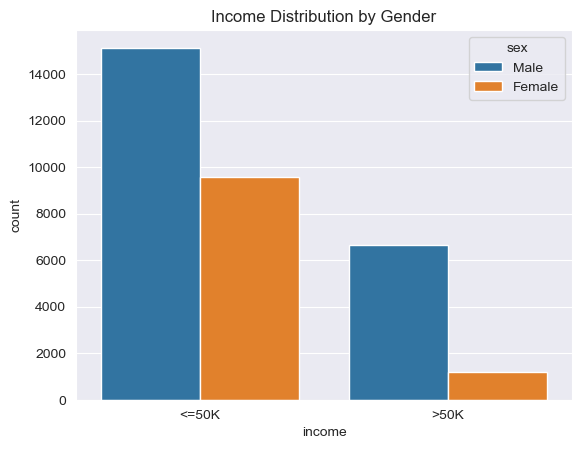

In [24]:

# =============================================================================
# 2. Visualize Bias in the Dataset
# =============================================================================

# Plot income distribution by gender
sns.countplot(data=df, x="income", hue="sex")
plt.title("Income Distribution by Gender")
plt.show()

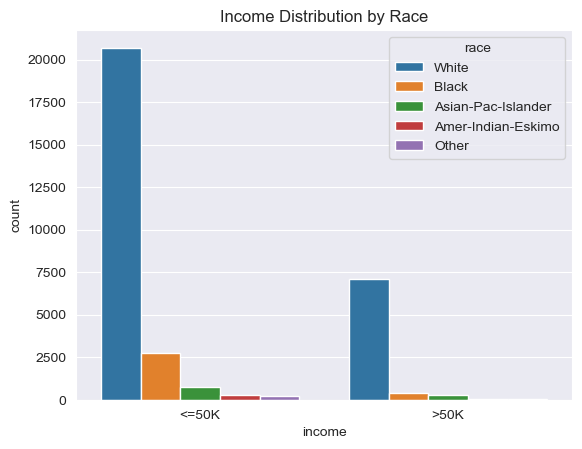

In [25]:

# Plot income distribution by race
sns.countplot(data=df, x="income", hue="race")
plt.title("Income Distribution by Race")
plt.show()

In [26]:

# =============================================================================
# 3. Define Bias Measurement Function (Disparate Impact Ratio)
# =============================================================================

def disparate_impact_ratio(df, protected_column, privilage_value, target_column, favorable_value):
    """
    Computes the Disparate Impact Ratio (DIR) for a protected attribute.
    
    Parameters:
      df: DataFrame containing the data.
      protected_column: The column name representing the protected attribute.
      privilage_value: The value of the protected attribute considered privileged.
      target_column: The column name representing the decision/outcome.
      favorable_value: The value of the outcome that is considered favorable.
      
    Returns:
      The ratio of the favorable outcome rate for the unprivileged group to that of the privileged group.
    """
    # Split the dataset into privileged and non-privileged groups
    privilage_group = df[df[protected_column] == privilage_value]
    protected_group = df[df[protected_column] != privilage_value]
    
    # Calculate the probability of a favorable outcome in both groups
    privilage_outcome = (privilage_group[target_column] == favorable_value).mean()
    protected_outcome = (protected_group[target_column] == favorable_value).mean()
    
    # Return the Disparate Impact Ratio
    return protected_outcome / privilage_outcome


In [27]:
# =============================================================================
# 4. Preprocess the Data and Encode Categorical Features
# =============================================================================

# Convert target variable "income" to binary (1 if >50K, else 0)
df["income"] = df["income"].apply(lambda x: 1 if x == ">50K" else 0)

# Compute initial fairness metrics on the raw data
dir_gender = disparate_impact_ratio(df, protected_column="sex", privilage_value="Male", target_column="income", favorable_value=1)
dir_race = disparate_impact_ratio(df, protected_column="race", privilage_value="White", target_column="income", favorable_value=1)
print(f"\nInitial Disparate Impact Ratio (Gender): {dir_gender:.3f}")
print(f"Initial Disparate Impact Ratio (Race): {dir_race:.3f}")

# Remove rows with missing values
df.dropna(inplace=True)

# Identify categorical columns to encode (excluding the target "income")
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# One-hot encode the categorical variables
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)



Initial Disparate Impact Ratio (Gender): 0.358
Initial Disparate Impact Ratio (Race): 0.596


In [28]:
# =============================================================================
# 5. Split the Data and Standardize Features
# =============================================================================

# Separate features and target variable
X = df.drop('income', axis=1)
y = df['income']

# Import modules for splitting and scaling
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features so that each feature has zero mean and unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [29]:
# =============================================================================
# 6. Train a Logistic Regression Model
# =============================================================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create and train the logistic regression model
# Note: Increase max_iter if the solver needs more iterations to converge.
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict outcomes on the test set and compute accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nInitial Model Accuracy: {accuracy:.3f}")



Initial Model Accuracy: 0.853


In [30]:

# =============================================================================
# 7. Bias Mitigation via Re-weighting (Resampling)
# =============================================================================

from imblearn.under_sampling import RandomUnderSampler

# Apply Random Under-Sampling to balance the classes
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Train a new logistic regression model on the resampled data
model_resampled = LogisticRegression(max_iter=1000)
model_resampled.fit(X_train_resampled, y_train_resampled)

# Predict outcomes using the model trained on resampled data and compute accuracy
y_pred_resampled = model_resampled.predict(X_test)
accuracy_resampled = accuracy_score(y_test, y_pred_resampled)
print(f"New Model Accuracy after Resampling: {accuracy_resampled:.3f}")


New Model Accuracy after Resampling: 0.811


In [31]:


# =============================================================================
# 8. Evaluation of Fairness After Mitigation
# =============================================================================

# Since the training and fairness evaluation were done on different representations,
# we evaluate DIR on the original (pre-encoded) dataset before dropping missing values.
# In a production setting, you would maintain the original protected attributes 
# separately to compute fairness metrics on model predictions.

# For demonstration, we assume that the resampling mitigation has affected the model predictions.
# In practice, you might compare predicted outcomes across groups (using original labels)
# to recalculate DIR. Here, we print a note indicating further steps would be needed.
print("\nNote: Fairness evaluation of model predictions requires mapping the resampled predictions "
      "back to the original protected attribute values. In this demo, we computed DIR on the raw data "
      "before encoding. Ensure that when deploying mitigation techniques, fairness metrics are evaluated "
      "on data that preserves protected attributes for proper comparison.")

print("\nBias mitigation process completed.")



Note: Fairness evaluation of model predictions requires mapping the resampled predictions back to the original protected attribute values. In this demo, we computed DIR on the raw data before encoding. Ensure that when deploying mitigation techniques, fairness metrics are evaluated on data that preserves protected attributes for proper comparison.

Bias mitigation process completed.
